---
title: "mrfmsim paper CERMIT algorithm comparison"
author: Peter Sun
date: 2024-10-29
toc: true
bib: reference.bib
---

The algorithm of Moore's 2009 PNAS [@Moore2009dec] was discussed in Isaac's thesis [@Isaac2018feb]. The conclusion was that (page 254) that the grid size used by Moore was too coarse (~ 20 nm), and 1 - 2 nm spacing is needed. Isaac also showed that the resulting slice is discontinuous (Figure 8.4).

![](Issac_thesis_page255.jpeg)

Upon close inspection the result is not intuitive because one would assume the discontinuation would be in the x direction. Also if the grid size is smaller than the cantilever peak to peak (660 nm in Moore's calculation), the result shouldn't be that much different.

Here we are going to reproduce Moore and Isaac's work. The Moore's work was included in the 2011 folder "mrfm simulation", and Isaac's work was included in mrfmsim/docs/test-cornellexpt-6.ipynb on Github/mrfmsim-archived commit 3cf075e.

The Marohn and Isaac's updated algorithm was modified (a small bug) and added to the current experiment list, under mrfmsim_marohn.experiment.CermitESR.

## Algorithm Comparison

The Moore's algorithm is taken from the matlab file under group dropbox mrfm_simulation and mrfm_simulation_results. They are attached in the folder. In particular, in PNAScopy5.m had comments
regarding the algorithm. This is all I have to recreate the old simulation (also in Sarah's folder).

```Matlab
% PNAScopy5.m
%
% John's comments:
% 
% The file runs a simulation to mimic Lei Chen's Oct 2011 experiments with
% a nickel tip in the SPAM geometry.
%
% Same as PNAScopy4.m, but increase tip-sample separation from 50 nm to 100
% nm.
% 
% Eric's comments:
% 
% This file runs a similar simulation to the one in Fig. 7 of the recent
% PNAS paper. Most of the parameters are specified either in the paper
% itself or in the supplement. I have not doubled checked all of them, and
% from the width of the signal something is off.  (Comparing to the paper is
% the best you can do, we don't have a copy of the original script used for
% the paper.)
%
% This simulation runs in just over 5 minutes on a good circa
% 2006 laptop, (9.6 million voxels, on a 1/2 model.)  
%
% If you are running on a computer with less than 1.5G of RAM you will
% likely want (or need) to reduce the mesh size, see nx, ny, nz starting on
% line 115 below. A good first reduction would be to nx = 800, ny = 10, nz
% = 400. (9.6 million to 3.2 million voxels).
%
% Eric Moore
% 2011.4.30

```

The algorithm used to calculate the saturation is:

```Matlab
for i = 1:numel(r.Bostep)
    % Here we are defining the spins that are in resonance at the beginning
    % of the cantilever swing.
    
    % I'm a little concerned that switching this from a for loop to this
    % vectorized expression incurs large costs in terms of creation of
    % temp objects.
    rescond = s.Binit + r.Bostep(i) - Brf;  % delta omega in field units
    sBnew = (1 + (rescond/deltaB).^2) ./ (1 + (rescond/deltaB).^2 + sterm); % s.s. bloch equation for Mz/M0
    
    % sBnew is poorly named.  It contains the percentage of the original
    % magnetizion that remains in each sample point (in steady state) due
    % to the applied rf field.
    
    % Now we're moving that slice through the sample. By translating the
    % sBnew in along the x-axis and keeping the most saturated (ie smallest
    % remaining magnetization that we calculate at each point.  I'm using
    % this set of nested loops to avoid creating a sample mesh sized
    % temporary. (Hopefully, the temporaries, if any are created as only
    % NY*NZ in size. I have not checked that this is true.)
    
    % the array we will eventually integrate over is this subset of s.Binit
    nxb = s.th+1;
    nxe = s.th+s.nx;

    % swing 1/2 ampl
    for k = 1:s.th
        for m = nxb:nxe
            sBnew(:,m-1,:) = min(sBnew(:,m-1,:), sBnew(:,m,:));
        end
    end
    
    % swing the other 1/2 ampl
    for k = 1:s.th
        for m = nxe:-1:nxb 
            sBnew(:,m+1,:) = min(sBnew(:,m+1,:), sBnew(:,m,:));
        end
    end
    
    % because we have calculated the remaining magnetization, but we really
    % need the magnetization that was lost, we need to subtract away what
    % remains, leaving what was lost.
    sBnew = 1-sBnew(:,nxb:nxe,:);
    
    % the number of spins in resonance
    % the 2 here and below is because we are calcuating a 1/2 model.
    r.nSFZ(i) = s.scale * r.rho * s.dV * sum(sBnew(:));
    % the simulated deltak
    % here we are resuing rescond, to prevent allocation of another giant
    % array.
    rescond = sBnew .* s.H;
    r.kAVG(i) = s.scale * r.mu * r.pol * r.rho * s.dV * sum(rescond(:));
    % assuming a spin noise experiment.
    rescond = rescond .* s.H  .* sBnew;
    r.kSQ(i) = s.scale * r.mu^2 * r.rho * s.dV * sum(rescond(:));
    nbksp = PrettyPrintKofN(i,numel(r.Bostep),nbksp);
end
```

The key function here is `sBnew(:,m-1,:) = min(sBnew(:,m-1,:), sBnew(:,m,:));`, simply keep the most saturated value between the given
sweep points. Here `s` is the sample object defined with the file "SampleCreate.m", "SampleFieldCreateSaturation.m", and `s.th` is number of grid points the cantilever swings; `s.nx` is the number of sample grid points in the x direction.

The algorithm goes like this:

Given a sample with step size `s.nx`. The cantilever motion extends the grid by `s.th`. The offset was calculated first for the extended grid, and then sliced according the step.

Here we are going to replace the "minimum absolute offset" to Moore's method. Based on "PNAS.m" and "SampleSweepSaturation.m", the algorithm is to find the minimum.

The algorithm is assume that the lowest in the sweep is the amount of final. This is actually underestimating because the algorithm does not account for the case when the spin crosses 0 and changes signs.

On the other end, Corinne's method is different.


In [2]:
import mrfmsim

from mrfmsim.experiment import CermitESRGroup

cermitesr = CermitESRGroup.experiments["CermitESR"]
# cermitesr.visualize()

## To get the source code of the node function
# import inspect

# func = cermitesr.get_node_object('minimum absolute x offset').func
# print(inspect.getsource(func))

In [3]:
import numpy as np


from mrfmsim.formula.math import as_strided_x


def min_abs_offset_moore(ext_B_offset, ext_pts):
    r"""Miminimal B offset using Moore algorithm.

    The returned value is the minial absolute offset.
    The sign does not matter because in the steady state saturation
    calculation, the b_offset**2 is used.

    The function calculates minimum absoluate offset during the
    cantilever sweep. For example, we define the window is 3 (1 extended pts at
    each side of the grid) and the B offset of the extended grid
    is (-4, -3, -2, -1, 1, 2, 3, 4, 5). We use _ to represent the extended pts and
    -- to represent the true grid points:

    __ -- -- -- -- -- -- -- __
    -3 -2 -1  1  2  3  4  5
    -4 -3 -2 -1  1  2  3  4  5
       -4 -3 -2 -1  1  2  3  4

    Moore algorithm result:

    __ -- -- -- -- -- -- -- __
    __  2  1  1  1  1  2  3 __

    In comparison, the Isaac-Marohn algorithm result:

    __ -- -- -- -- -- -- -- __
    __  2  1  0  0  1  2  3 __

    """
    window = 2 * ext_pts + 1
    b_offset_abs_strided = as_strided_x(abs(ext_B_offset), window)

    return b_offset_abs_strided.min(axis=1)


# cermitesr_moore.visualize()

Here we replicate the algorithm in Python. We can test and compare the algorithm.
The algorithm uses the same `as_strided_x` as CermitESR, basically extend the grid view
in the x direction to save memory and increase performance.

We will test the algorithm with a 1D array.

In [4]:
def test_min_abs_offset_moore():
    """Test min_abs_offset_moore function."""
    ext_B_offset = np.array([-4, -3, -2, -1, 1, 2, 3, 4, 5])
    ext_pts = 1
    expected = np.array([2, 1, 1, 1, 1, 2, 3])
    return np.array_equal(min_abs_offset_moore(ext_B_offset, ext_pts), expected)


test_min_abs_offset_moore()

True

The algorithm from mrfmsim-marohn is efficient, however, the peak memory creates three two copies of the array during the zero corssing calculation.

However, alternative algorithms that reduces the peak memory usage, but extremely slow (even the jit options).
The commented out code below is one example.

In [5]:
# min_abs_offset_isaac = cermitesr.get_node_object("minimum absolute x offset").func

# def min_abs_value(value):
#     """Find the minimum offset value.

#     If the seqence os value crosses zero, it should be 0. Otherwise
#     take the absolute value of the minimum value.
#     """

#     if (np.all(value > 0) or np.all(value < 0)):
#         return np.abs(value).min()
#     else:
#         return 0


# def min_abs_offset_isaac_modified(ext_B_offset, ext_pts):
#     """Miminimal B offset using Isaac algorithm.

#     The attempt to save memory during the calculation.
#     However this is extremely slow due to teh apply_along_axis function
#     not being vectorized.
#     """

#     window = 2 * ext_pts + 1
#     b_offset_strided = as_strided_x(ext_B_offset, window)

#     return np.apply_along_axis(min_abs_value, axis=1, arr=b_offset_strided)


# ext_B_offset = np.random.rand(5, 10, 100)
# ext_pts = 1

# %%timeit
# min_abs_offset_isaac(ext_B_offset, ext_pts)

# %%timeit
# min_abs_offset_isaac_modified(ext_B_offset, ext_pts)

In [6]:
min_abs_offset_isaac = cermitesr.get_node_object("minimum absolute x offset").func


def test_min_abs_offset_isaac():
    """Test min_abs_offset_isaac function."""
    ext_B_offset = np.array([-4, -3, -2, -1, 1, 2, 3, 4, 5])
    ext_pts = 1
    expected = np.array([2, 1, 0, 0, 1, 2, 3])
    # return np.array_equal(min_abs_offset_isaac(ext_B_offset, ext_pts), expected)
    np.testing.assert_array_equal(min_abs_offset_isaac(ext_B_offset, ext_pts), expected)


test_min_abs_offset_isaac()

The difference between the algorithm is quite clear. Given the assumption that the spins
saturates immediately, the Moore's algorithm underestimates the effect. The underestimation
also depends on the grid step size. In the previous example, a smaller the grid step size,
the closer the value is to the Isaac's algorithm. 

Now with the time dependent offset physics, we know that the assumption stated above drastically
overestimate the local spins.

Here we compare Moore's algorithm and Isaac's algorithm for the 2009 experiment.
Here we use the same dataset as the mrfmsim paper.

Here we look at two different tip sample separation for comparison.



import scipy.io
mat = scipy.io.loadmat("data/moore/20090303 Distance Dependence.mat")
mat['data'].shape[1]

mat["data"][0, 12][0, 0][3][0]

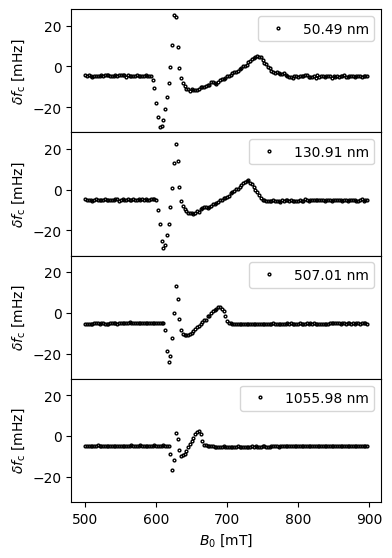

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import glob


def extract_ESR_phase_cor(filename):
    data = pd.read_csv(filename,sep =',', header =0)
    field_mT = data['field [T]']
    lockin_x = data['lock-x [mHz]']
    dist_nm = data['distance [nm]'][0]
        
    return field_mT, lockin_x, dist_nm


data_files = glob.glob('data/moore/*_rephase.csv')

data2009 = []

for file in data_files:
    data2009.append(extract_ESR_phase_cor(file))

data2009 = sorted(data2009, key = lambda x: x[2])
d_list = [d[2] for d in data2009]
# x50, y50, d50 = extract_ESR_phase_cor('data/moore/Moore2009dec_50nm_rephase.csv')
# x130, y130, d130 = extract_ESR_phase_cor('data/moore/Moore2009dec_130nm_rephase.csv')
# x507, y507, d507 = extract_ESR_phase_cor('data/moore/Moore2009dec_507nm_rephase.csv')
# x1055, y1055, d1055 = extract_ESR_phase_cor('data/moore/Moore2009dec_1055nm_rephase.csv')

# plt.plot(x50,-1*y50,label = f'{d50[0]:.2f} nm', color='black')
# plt.plot(x130,-1*y130 +50,label = f'{d130[0]:.2f} nm', color='black')
# plt.plot(x507,-1*y507+90,label = f'{d507[0]:.2f} nm', color='black')
# plt.plot(x1055,-1*y1055+120,label = f'{d1055[0]:.2f} nm', color='black')
# for i in range(len(data2009)):
#     plt.plot(data2009[i][0], -1*data2009[i][1] + 50*i, label = f'{data2009[i][2]:.2f} nm')

fig = plt.figure(figsize=(4, 1.6 * len(data2009)))

gs = fig.add_gridspec(len(data2009), hspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for i, (x, y, d) in enumerate(data2009):
    axs[i].plot(
        x * 1000,
        -1 * y,
        "o",
        mfc="none",
        color="black",
        markersize=2,
        label=f"{d:.2f} nm",
    )
    # B_larmor = cermitesr.get_node_object("larmor field").func(d)
    # axs[i].plot(
    #     B0_list - 2.5, np.array(df_spin_list[i]), "-", color="teal", label="simulation"
    # )
    # axs[i].vlines(
    #     x=B_larmor - 2.5,
    #     ymin=-12,
    #     ymax=12,
    #     color="grey",
    #     linestyles="dashed",
    #     # label="Larmor",
    # )

    axs[i].legend(loc="upper right")
    axs[i].set_ylabel('$\delta f_{\mathrm{c}}$ [mHz]')


plt.xlabel('$B_0$ [mT]')
# plt.ylabel('$\delta f_{\mathrm{c}}$ [mHz]')
plt.legend(loc ='upper right')
plt.savefig('moore_data.png')
plt.show()

In [7]:
# from matprocess import parse_mat

# data = parse_mat("data/moore/20090303 Distance Dependence.mat")

# data.keys()

In [8]:
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = 8, 6

# for i, h in enumerate([49.84, 119.5]):

#     plt.plot(
#         data[h].F * 100,
#         data[h].X * 1000.0 + 25 * i,
#         mfc="none",
#         color="black",
#         markersize=2,
#     )
#     plt.text(770, 25 * i + 4, str(h) + " nm")
# plt.xlabel("$B_0$ [mT]")
# plt.ylabel(r"$\delta f_c$ [mHz]")
# plt.tight_layout()
# plt.title("Moore 2008 vary tip sample separation")
# # plt.savefig("moore_vary_tip_sample.pdf")
# plt.show()

In [9]:
data2009[0][0]

0      0.4999
1      0.5025
2      0.5050
3      0.5075
4      0.5100
        ...  
155    0.8875
156    0.8900
157    0.8925
158    0.8950
159    0.8975
Name: field [T], Length: 160, dtype: float64

### Conversion to float32

Due to multiple copies of during the calculation, here we convert all parameters into float32 during calculation.
The simpliest thing is to convert all intermediate data to float32. Some operations are repeated, but overall
we still improve performance.

In [9]:
from functools import wraps


def convert_float32(value):
    """Convert float, numpy array and list of float to float32.

    Here we assume all lists used in the cermitesr is a list of float
    or int.
    """
    if isinstance(value, np.ndarray) or isinstance(value, float):
        return np.float32(value)
    elif isinstance(value, list) or isinstance(value, tuple):
        v_list = []
        for v in value:
            if isinstance(v, int):
                v_list.append(v)
            else:
                v_list.append(np.float32(v))

        return type(value)(v_list)
    return value


def float32_modifier(func):
    """Modifier to convert all input and output to float32."""

    @wraps(func)
    def wrapper(**kwargs):

        kwargs32 = {key: convert_float32(value) for key, value in kwargs.items()}

        return convert_float32(func(**kwargs32))

    return wrapper

In [10]:
cermitesr32 = cermitesr.edit(modifiers=[float32_modifier])

for node in cermitesr32.graph.nodes:
    cermitesr32 = cermitesr32.edit_node(node, modifiers=[float32_modifier])

cermitesr_moore32 = cermitesr32.edit_node(
    "minimum absolute x offset", func=min_abs_offset_moore
)

## Appendix

In the paper appendix, we also compare the Moore algorithm with Isaac's algorithm.

Particularly, we focus the three B fields (645, 657.5, 707.5 mT) with at 358.7 nm. First we implement the CERMITESRs.



In [11]:
from mrfmsim.component import SphereMagnet, Grid, Sample, Cantilever
import numpy as np

magnet = SphereMagnet(magnet_radius=1375.9, mu0_Ms=523.1, magnet_origin=[0, 1375.9, 0.0])
sample = Sample(spin="e", T1=1.3e-3, T2=0.45e-6, spin_density=0.0241, temperature=11.0)
# eric moore spam geometry, very shallow grid
# grid = Grid(shape=(1201, 21, 2401), step=[10.0, 10.0, 10.0], origin=[0.0, -100.0, 0.0])
grid = Grid(grid_shape=(501, 11, 1101), grid_step=[20.0, 20.0, 20.0], grid_origin=[0.0, -100.0, 0.0])
cantilever = Cantilever(k_c=7.8e2, f_c=5.512e3)

# we use the same coil constant
c_uT = 1.0 / 1.2  # coil constant uT^2/mW
dBm = -10.0  # dB gain
power = 10.0 ** ((dBm + 20.0) / 10.0)  # mW
B1 = np.sqrt(power * c_uT) / 1000.0  # mT
x_0p = 164.0
tip_v = x_0p * cantilever.f_c * 2 * np.pi

# eric pulses every three cycles
dt_step = 1 / cantilever.f_c * 3
f_rf = 18.1e9  # Hz


h_list = ([[0, d, 0] for d in d_list])  # tip sample separation [nm]
mw_x_0p = x_0p  # zero to peak amplitude of the cantilever motion [nm]

B0_list = np.arange(600, 800, 5)

In [12]:
print(cermitesr32)

CermitESR(B0, B1, cantilever, f_rf, grid, h, magnet, mw_x_0p, sample)
returns: df_spin
group: CermitESRGroup
graph: CermitESR_graph
handler: MemHandler
modifiers:
- float32_modifier

CERMIT ESR experiment for a large tip.


In [13]:
sig64 = cermitesr(
    B0_list[20], B1, cantilever, f_rf, grid, h_list[0], magnet, mw_x_0p, sample
)
sig32 = cermitesr32(
    B0_list[20], B1, cantilever, f_rf, grid, h_list[0], magnet, mw_x_0p, sample
)

print(
    f"signal calculated with float64 at 50 nm tip sample separation: {sig64} and float32: {sig32}"
)

signal calculated with float64 at 50 nm tip sample separation: -54.46350870386132 and float32: -54.46344757080078


### Comparison between different algorithms

Here we are going to use the parameters used for time dependent algorithm.

The grid used here has the shape of (1201, 11, 1201) and step size of
(20, 20, 20) nm. The effective grid size is 24.02 um x 220 nm x 24.02 um.

We pick two different tip sample separation to plot.


In [15]:
from mmodel.shortcut import loop_shortcut

cermitesr32_loop = loop_shortcut(loop_shortcut(cermitesr32, "B0"), "h")

isaac_result = cermitesr32_loop(
    B0_list, B1, cantilever, f_rf, grid, h_list, magnet, mw_x_0p, sample
)

In [16]:
from mmodel.shortcut import loop_shortcut

cermitesr_moore32_loop = loop_shortcut(loop_shortcut(cermitesr_moore32, "B0"), "h")

moore_result = cermitesr_moore32_loop(
    B0_list, B1, cantilever, f_rf, grid, h_list, magnet, mw_x_0p, sample
)

In [17]:
from mrfmsim.experiment import CermitTDGroup
from mmodel.shortcut import loop_shortcut

cermittd = CermitTDGroup.experiments["CermitTD"]

cermittd32 = cermittd.edit(modifiers=[float32_modifier])
for node in cermittd32.graph.nodes:
    cermittd32 = cermittd32.edit_node(node, modifiers=[float32_modifier])

cermittd_loop = loop_shortcut(loop_shortcut(cermittd32, "B0"), "h")

cermittd_result = cermittd_loop(
    B0_list, B1, cantilever, dt_step, f_rf, grid, h_list, magnet, x_0p, sample, tip_v
)

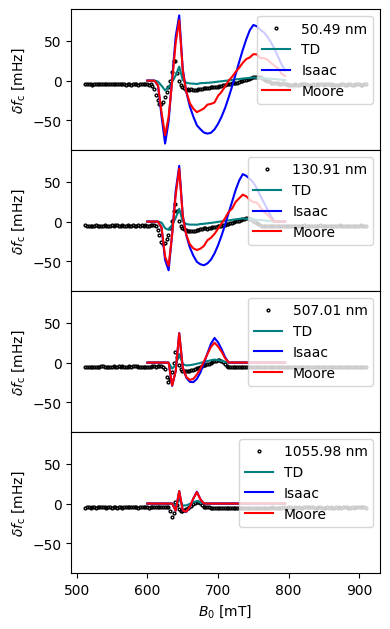

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 1.6 * len(data2009)))

gs = fig.add_gridspec(len(data2009), hspace=0.0)
axs = gs.subplots(sharex=True, sharey=True)

for i, (x, y, d) in enumerate(data2009):
    axs[i].plot(
        x * 1000 + 12,
        -1 * y,
        "o",
        mfc="none",
        color="black",
        markersize=2,
        label=f"{d:.2f} nm",
    )
    
    axs[i].plot(B0_list, cermittd_result[i], color="teal", label="TD")
    axs[i].plot(B0_list, isaac_result[i], color="blue", label="Isaac")
    axs[i].plot(B0_list, moore_result[i], color="red", label="Moore")
    axs[i].legend(loc="upper right")
    axs[i].set_ylabel('$\delta f_{\mathrm{c}}$ [mHz]')


plt.rcParams["figure.figsize"] = 8, 6

# for i, h in enumerate(h_list):
#     plot_offset = 100 * i

#     plt.plot(
#         data[h].F * 100 + 2.5,
#         data[h].X * 1000.0 + plot_offset,
#         mfc="none",
#         color="black",
#         markersize=2,
#     )
#     plt.text(770, plot_offset + 4, "h=" + str(h) + " nm")
#     plt.plot(B0_list, cermittd_result[i] + plot_offset, color="red", label=f"TD")
#     plt.plot(B0_list, isaac_result[i] + plot_offset, color="blue", label=f"Isaac")
#     plt.plot(B0_list, moore_result[i] + plot_offset, color="green", label=f"Moore")
#     # plt.plot(B0_list, np.array(moore_result[i]) / 3, label=f"Moore downscaled by 3")

plt.xlabel("$B_0$ [mT]")
# plt.ylabel(r"$\delta f_c$ [mHz]")
# plt.legend(["Exp Data", "TD", "Isaac", "Moore"])
# plt.suptitle(
#     "Comparison of Isaac, Moore and Time Dependent Offset algorithms\n"
#     "(Boucher Parmaeters, signal -2.5 mT offset)"
# )
plt.tight_layout()

# plt.savefig("moore_vary_tip_sample.pdf")
plt.show()

The fittin result from Isaac and Moore is very different from the data collected.
The original algorithm uses different parameters specically B1.

In the following we use parameters that uses the parmameters moore used in the 2009 paper.
Here we change the grid size in x direction to demonstrate the effect of grid size.
The grid size is effectively 24.02 um x 220 nm x 24.02 um. We change the grid step size
in the direction at 20 nm, 10 nm, 5 nm, 2 nm, and 1 nm.

In [20]:
moore_magnet = SphereMagnet(magnet_radius=1850, mu0_Ms=440, magnet_origin=[0, 1850, 0.0])
grid_10nm = Grid(grid_shape=(2401, 11, 1201), grid_step=[10, 20, 20], grid_origin=[0.0, -100.0, 0.0])
grid_5nm = Grid(grid_shape=(4801, 11, 1201), grid_step=[5, 20, 20], grid_origin=[0.0, -100.0, 0.0])
grid_2_5nm = Grid(grid_shape=(9601, 11, 1350), grid_step=[2.5, 20, 20], grid_origin=[0.0, -100.0, 0.0])
moore_cantilever = Cantilever(k_c=7.8e2, f_c=5.512e3)

B1 = 3.9 / 10000

x_0p = 164.0
f_rf = 18.1e9  # Hz

mw_x_0p = x_0p  # zero to peak amplitude of the cantilever motion [nm]

In [21]:
moore_result_10nm = cermitesr_moore32_loop(
    B0_list,
    B1,
    moore_cantilever,
    f_rf,
    grid_10nm,
    h_list,
    moore_magnet,
    mw_x_0p,
    sample,
)

moore_result_5nm = cermitesr_moore32_loop(
    B0_list, B1, moore_cantilever, f_rf, grid_5nm, h_list, moore_magnet, mw_x_0p, sample
)

moore_result_2_5nm = cermitesr_moore32_loop(
    B0_list,
    B1,
    moore_cantilever,
    f_rf,
    grid_2_5nm,
    h_list,
    moore_magnet,
    mw_x_0p,
    sample,
)

In [22]:
issac_result_10nm = cermitesr32_loop(
    B0_list, B1, cantilever, f_rf, grid_10nm, h_list, magnet, mw_x_0p, sample
)

issac_result_5nm = cermitesr32_loop(
    B0_list, B1, cantilever, f_rf, grid_5nm, h_list, magnet, mw_x_0p, sample
)

# memory leak
# issac_result_2_5nm = cermitesr32_loop(
#     B0_list, B1, cantilever, f_rf, grid_2_5nm, h_list, magnet, mw_x_0p, sample
# )

In [23]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 8, 6

for i, h in enumerate([53, 972.2]):
    plot_offset = 100 * i

    plt.plot(
        data[h].F * 100 + 2.5,
        data[h].X * 1000.0 + plot_offset,
        mfc="none",
        color="black",
        markersize=2,
    )
    plt.text(770, plot_offset + 4, "h=" + str(h) + " nm")
    # plt.plot(B0_list, cermittd_result[i] + plot_offset, label=f"TD")
    plt.plot(B0_list, moore_result[i] + plot_offset, label=f"Moore")

    plt.plot(B0_list, moore_result_10nm[i] + plot_offset, label=f"Moore 10 nm at {h} nm")
    plt.plot(B0_list, moore_result_5nm[i] + plot_offset, label=f"Moore 5 nm at {h} nm")
    plt.plot(
        B0_list, moore_result_2_5nm[i] + plot_offset, label=f"Moore 2.5 nm at {h} nm"
    )
    plt.plot(B0_list, issac_result_10nm[i] + plot_offset, label=f"Isaac 10 nm at {h} nm")
    plt.plot(B0_list, issac_result_5nm[i] + plot_offset,  label=f"Isaac 5 nm at {h} nm")
    # plt.plot(B0_list, np.array(moore_result[i]) / 3, label=f"Moore downscaled by 3")

plt.xlabel("$B_0$ [mT]")
plt.ylabel(r"$\delta f_c$ [mHz]")
# plt.legend(["Exp Data", "TD", "Isaac", "Moore"])
plt.legend(loc="upper right")
plt.tight_layout()
plt.title(
    "Comparison of Isaac, Moore and Time Dependent Offset algorithms\n"
    "(Boucher Parmaeters, signal -2.5 mT offset)"
)
# plt.savefig("moore_vary_tip_sample.pdf")
plt.show()

NameError: name 'data' is not defined